# Real Data Experiment 1

## Setup

In [67]:
using CSV
using DataFrames
using Distributions
using LinearAlgebra
using ProgressMeter

In [104]:
using Gadfly
import Cairo, Fontconfig

In [57]:
using FuzzySGM

In [74]:
ENV["COLUMNS"] = 1000;

## Load Graph

In [19]:
edges = Tuple{Int,Int}[]
open("experment51/sub-0025920_ses-2_dwi_DS00833.edgelist.txt") do f
    graph_data_text = readlines(f)
    for line in graph_data_text
        v1, v2, w = parse.(Int, split(line, " "))
        push!(edges, (v1,v2))
    end
end
edges = hcat([e[1] for e in edges], [e[2] for e in edges]);

In [26]:
vtxs = sort(unique(edges))
vtx_to_idx = Dict(v => i for (i,v) in enumerate(vtxs));

In [27]:
N = length(vtxs);
E = size(edges, 1);

In [47]:
G = BitArray(zeros(Bool, N, N))
for i in 1:E
    u1, u2 = edges[i,:]
    v1, v2 = vtx_to_idx[u1], vtx_to_idx[u2]
    G[v1,v2] = 1
end
G = G .| G';

In [111]:
p = sum(G) / binomial(N,2) / 2

0.03606292476593318

## Generate Random Graph

In [116]:
H = BitArray(rand(N,N) .< p);

In [117]:
pH = sum(H) / binomial(N,2) / 2

0.03605025109706446

## Graph Matching

In [69]:
function run_matching(graphA, graphB, matching, m; maxiter::Int=20)
    sgm_time = @elapsed P, est_matching, it = FuzzySGM.sgm(graphA, graphB, m, maxiter=maxiter, return_iter=true)

    match_r    = FuzzySGM.match_ratio(matching, est_matching, m)
    algn_str_1 = FuzzySGM.alignment_strength(graphA, graphB, P, m)
    algn_str_2 = FuzzySGM.alignment_strength(graphA, graphB, P, 0)

    results = (
        match_ratio = match_r,
        alignment_strength_1 = algn_str_1,
        alignment_strength_2 = algn_str_2,
        iter = it, maxiter = maxiter, sgm_time = sgm_time,
        experiment = "51",
    )
    return results
end;

In [68]:
function interpolate_graphs(graphA, graphB, ρ)
    p_matrix = (ρ .* graphA) + ((1 - ρ) .* graphB)
    N = size(graphA, 1)
    graphC = zeros(Int, N, N)
    for i in 1:N
        for j in i+1:N
            graphC[i,j] = rand(Bernoulli(p_matrix[i,j]))
        end
    end
    graphC = graphC + graphC'
    matching = hcat(1:N, 1:N)
    return graphC
end;

In [80]:
# p_matrix = (ρe .* graphA) + ((1 - ρe) .* graphB)
# μ = mean(p_matrix)
# σ = std(p_matrix)
# ρh = (σ^2) / (μ * (1 - μ))
# ρt = 1 - ((1-ρe) * (1-ρh))

In [136]:
_graphA = Int.(G)
_graphB = Int.(H)
_ρe = 0.5
_p_matrix = (_ρe .* _graphA) + ((1 - _ρe) .* _graphB)
μ = mean(_p_matrix)
σ = std(_p_matrix)
ρh = (σ^2) / (μ * (1 - μ))

0.49959934628092545

In [70]:
m = 50;

In [149]:
iterations = collect(1:10)
ρes = collect(0.0:0.025:1.0)
params = collect(Iterators.product(iterations, ρes))[:];

In [156]:
# results_data = NamedTuple[]
@showprogress for (i,ρe) in params
    graphA = Int.(G)
    graphB = interpolate_graphs(graphA, Int.(H), ρe)
    graphA, graphB, matching = FuzzySGM.seed_random(graphA, graphB, m)
    
    pA = sum(graphA) / binomial(N,2) / 2
    pB = sum(graphB) / binomial(N,2) / 2
    
    r = run_matching(graphA, graphB, matching, m)
    r = merge(r, (
        ρe = ρe,
        pA = pA,
        pB = pB,
    ))
    push!(results_data, r)
end
results = DataFrame(results_data);

Progress: 100%|█████████████████████████████████████████| Time: 0:44:49


In [150]:
results_data_synthetic = NamedTuple[]
@showprogress for (i,ρe) in params
    graphA, graphB, matching = FuzzySGM.generate_erdosrenyi(N, p, ρe)
    graphA, graphB, matching = FuzzySGM.seed_random(graphA, graphB, m)
    
    r = run_matching(graphA, graphB, matching, m)
    r = merge(r, (
        ρe = ρe,
    ))
    push!(results_data_synthetic, r)
end
results_synthetic = DataFrame(results_data_synthetic);

Progress: 100%|█████████████████████████████████████████| Time: 0:21:51


## Analysis

In [77]:
function get_match_ratio_colorid(x)
    if x == 1.0
        return 4
    elseif x >= 0.85
        return 3
    elseif x >= 0.5
        return 2
    else
        return 1
    end
end;

In [85]:
colors = [colorant"red", colorant"darkblue", colorant"deepskyblue", colorant"green"]

In [88]:
defaultfont = "CMU Serif";
fontstyles = (
    key_title_font = defaultfont,
    key_label_font = defaultfont,
    minor_label_font = defaultfont,
    major_label_font = defaultfont,
    key_title_font_size = 14px,
    key_label_font_size = 12px,
    minor_label_font_size = 14px,
    major_label_font_size = 16px,
);

In [157]:
results.match_color = map(get_match_ratio_colorid, results.match_ratio);
results_synthetic.match_color = map(get_match_ratio_colorid, results_synthetic.match_ratio);

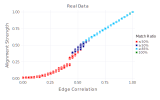

In [164]:
plt = plot(
    results,
    x=:ρe, y=:alignment_strength_1, color=:match_color,
    Geom.point,
    
    Guide.xlabel("Edge Correlation"),
    Guide.ylabel("Alignment Strength"),
    Guide.title("Real Data"),
    
    Scale.color_discrete_manual(colors..., levels=[1,2,3,4]),
    Guide.colorkey(title="Match Ratio", labels=["≤50%", "≥50%", "≥85%", "100%"]),
    
    Guide.xticks(ticks=0:0.25:1),
    Guide.yticks(ticks=0:0.25:1),
    
    style(
        ;fontstyles...,
    ),
)
plt |> SVG(16cm, 10cm)
plt |> PDF("exp45_fig1_v1.pdf", 16cm, 10cm)

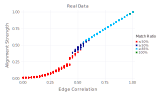

In [163]:
plt = plot(
    results,
    x=:ρe, y=:alignment_strength_1, color=:match_color,
    Geom.point,
    
    Guide.xlabel("Edge Correlation"),
    Guide.ylabel("Alignment Strength"),
    Guide.title("Real Data"),
    
    Scale.color_discrete_manual(colors..., levels=[1,2,3,4]),
    Guide.colorkey(title="Match Ratio", labels=["≤50%", "≥50%", "≥85%", "100%"]),
    
    Guide.xticks(ticks=0:0.25:1),
    Guide.yticks(ticks=0:0.25:1),
    
    style(
        highlight_width=0px,
        point_size=0.6mm,
        ;fontstyles...,
    ),
)
plt |> SVG(16cm, 10cm)
plt |> PDF("exp45_fig1_v2.pdf", 16cm, 10cm)

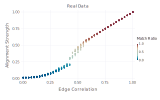

In [165]:
plt = plot(
    results,
    x=:ρe, y=:alignment_strength_1, color=:match_ratio,
    Geom.point,
    
    Guide.xlabel("Edge Correlation"),
    Guide.ylabel("Alignment Strength"),
    Guide.title("Real Data"),
    
    Guide.colorkey(title="Match Ratio"),
    
    Guide.xticks(ticks=0:0.25:1),
    Guide.yticks(ticks=0:0.25:1),
    
    style(
        highlight_width=0px,
        point_size=0.6mm,
        ;fontstyles...,
    ),
)
plt |> SVG(16cm, 10cm)
plt |> PDF("exp45_fig1_v3.pdf", 16cm, 10cm)

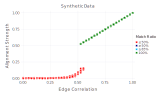

In [161]:
plt = plot(
    results_synthetic,
    x=:ρe, y=:alignment_strength_1, color=:match_color,
    Geom.point,
    
    Guide.xlabel("Edge Correlation"),
    Guide.ylabel("Alignment Strength"),
    Guide.title("Synthetic Data"),
    
    Scale.color_discrete_manual(colors..., levels=[1,2,3,4]),
    Guide.colorkey(title="Match Ratio", labels=["≤50%", "≥50%", "≥85%", "100%"]),
    
    Guide.xticks(ticks=0:0.25:1),
    Guide.yticks(ticks=0:0.25:1),
    
    style(
        ;fontstyles...,
    ),
)
plt |> SVG(16cm, 10cm)
plt |> PDF("exp45_fig2_v1.pdf", 16cm, 10cm)